In [2]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pathlib

In [4]:
import numpy as np
import pandas as pd

In [5]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [6]:
df = pd.read_csv("data/AEP_hourly.csv", parse_dates=["Datetime"], index_col="Datetime")

## Fix timestamps

In [7]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [8]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [9]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [10]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [11]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

## Missing values

In [12]:
dfi.ffill(inplace=True)

# DalaModule

In [13]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [14]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))


class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [43]:
ds = ElectricityDataset(dfi, 10)

hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

# Encoder-decoder model with attention

In [90]:
class ElectricityAttnModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model with attention."""
   
    def __init__(self,
                 hist_len=168,
                 fct_len=24,
                 ar_len=12,
                 num_layers=1,
                 hidden_units=8,
                 lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.ar_len = ar_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.encoder = nn.GRUCell(input_size=1,
                                  hidden_size=self.hidden_units)
        self.decoder = nn.GRUCell(input_size=1,
                                  hidden_size=self.hidden_units)

        self.attn_merged = nn.Linear(2 * self.hidden_units, self.hidden_units)
        self.fct = nn.Linear(self.hidden_units, 1)

    def forward(self, x):
        forecasts = []
        encoder_hiddens = []
        decoder_hiddens = []
        attn_scores = []

        encoder_hidden = self.encoder(x[:, [0]])  # encoder_hidden: (N, hidden_units)
        encoder_hiddens.append(encoder_hidden)

        # Calculating encoder hidden states
        for i in range(1, self.hist_len):
            encoder_hidden = self.encoder(x[:, [i]], encoder_hidden)
            encoder_hiddens.append(encoder_hidden)

        encoder_hiddens = torch.stack(encoder_hiddens, dim=0)

        # Calculating decoder hidden states
        decoder_hidden = encoder_hidden
        decoder_input = x[:, [-1]]

        for i in range(0, self.fct_len):
            decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            step_attn_scores = F.softmax(torch.sum(encoder_hiddens * decoder_hidden.unsqueeze(0),
                                                   dim=-1),
                                         dim=0)

            weighted = torch.sum(step_attn_scores.unsqueeze(dim=-1) * encoder_hiddens,
                                 dim=0)

            fct = self.attn_merged(torch.cat((weighted, decoder_hidden),
                                             dim=-1))

            attn_scores.append(step_attn_scores)

            decoder_hiddens.append(decoder_hidden)
            decoder_output = self.fct(fct)
            forecasts.append(decoder_output)
            decoder_input = decoder_output

        forecasts = torch.cat(forecasts, dim=1)

        return torch.stack(attn_scores, dim=0), forecasts

    def step(self, batch, batch_idx, stage="train"):
        x, y = batch
        attn, fct = self(x)
        loss = F.mse_loss(fct, y)
        self.log(f"{stage}_mse", loss, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, stage="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, stage="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [91]:
model = ElectricityAttnModel()
attn, fct = model(hist_sample)

In [92]:
attn.shape, fct.shape

(torch.Size([24, 168, 2]), torch.Size([2, 24]))

# Training

In [19]:
LIMH, LIML =26e3, 9e3

In [94]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)
model = ElectricityAttnModel(lr=1e-3, hidden_units=64)

In [95]:
ds = ElectricityDataModule(dfs, batch_size=32)

In [99]:
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1)
trainer.fit(model, ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type    | Params
----------------------------------------
0 | encoder     | GRUCell | 12.9 K
1 | decoder     | GRUCell | 12.9 K
2 | attn_merged | Linear  | 8.3 K 
3 | fct         | Linear  | 65    
----------------------------------------
34.0 K    Trainable params
0         Non-trainable params
34.0 K    Total params
0.136     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [100]:
hist_sample_scaled = (2 * hist_sample - LIML - LIMH) / (LIMH - LIML)

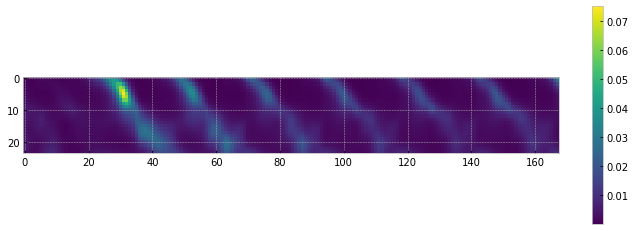

In [101]:
plt.imshow(model(hist_sample_scaled)[0].detach().numpy()[..., 0])
plt.colorbar()

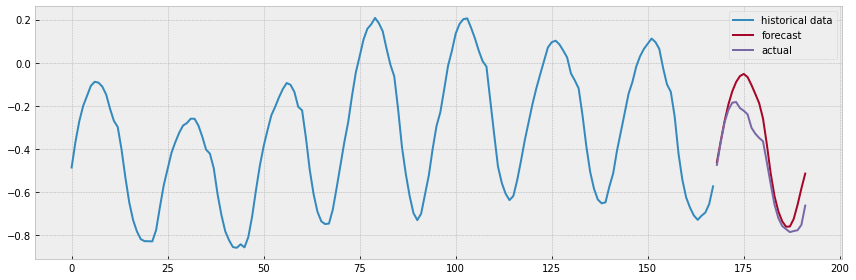

In [102]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled)[1].detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()

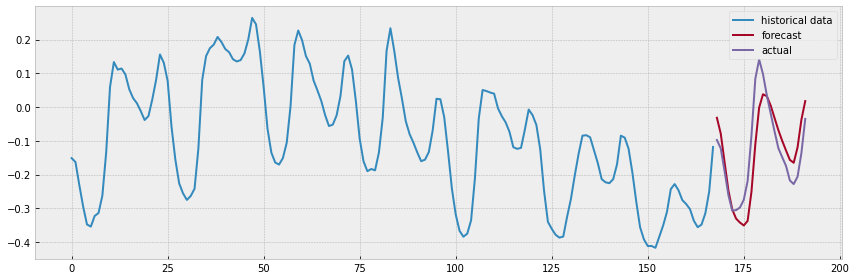

In [103]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled)[1].detach().numpy()[1], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="actual")

plt.legend(loc=0)
plt.tight_layout()

In [104]:
dl = ds.val_dataloader()

In [105]:
for x in dl:
    fct = model(x[0])
    break

In [106]:
fct = fct[1].detach().numpy()

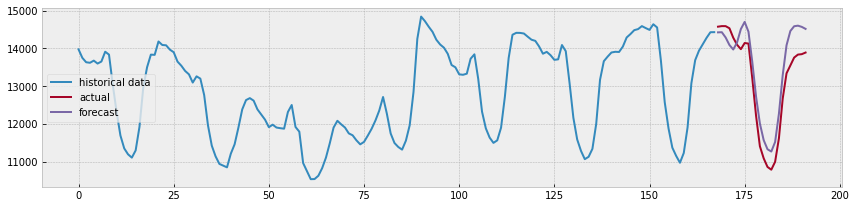

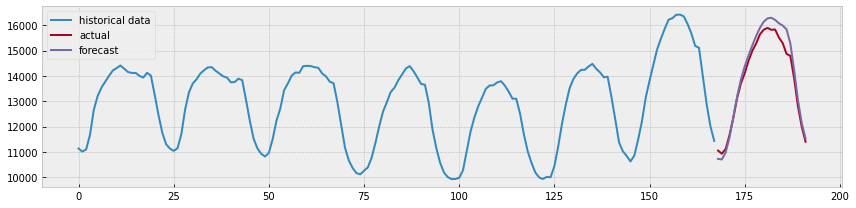

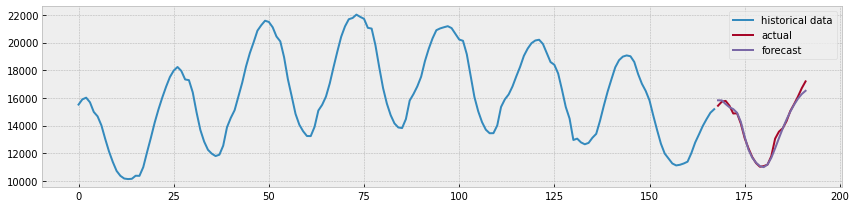

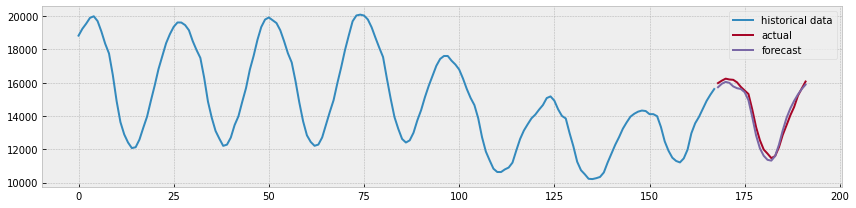

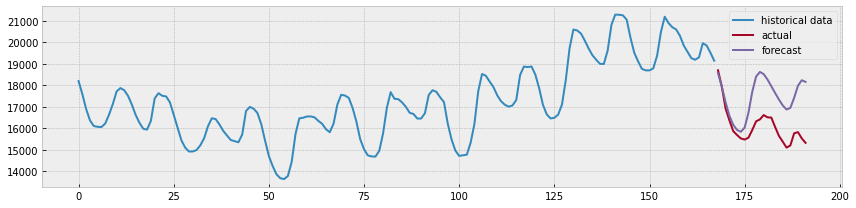

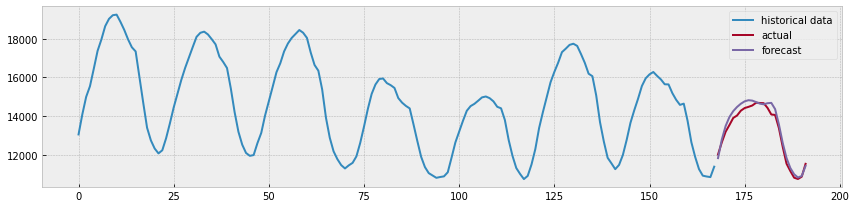

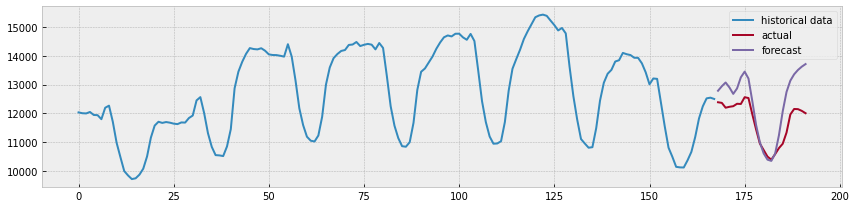

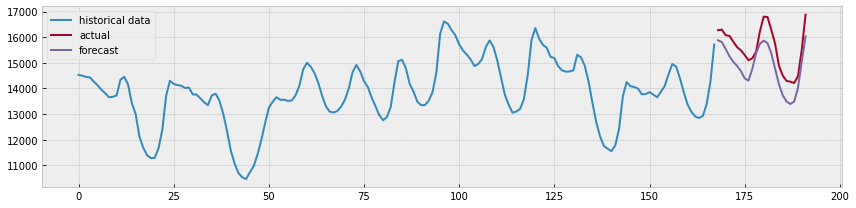

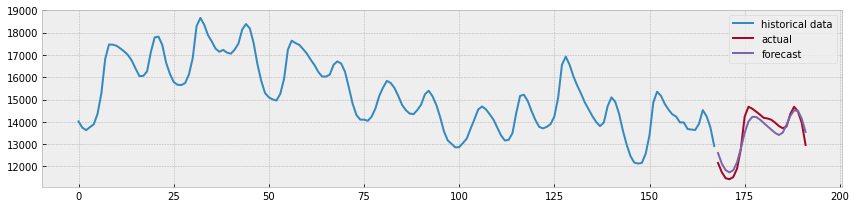

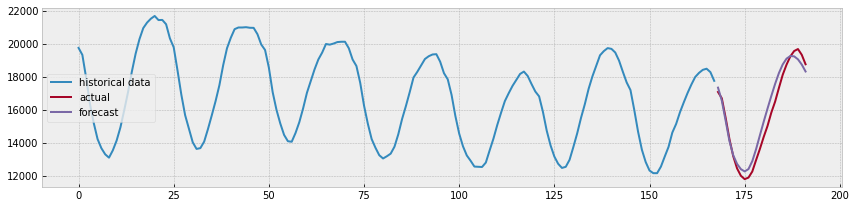

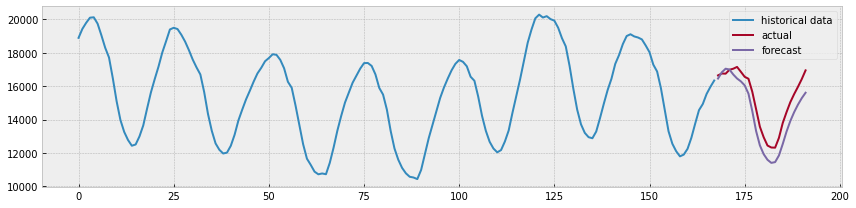

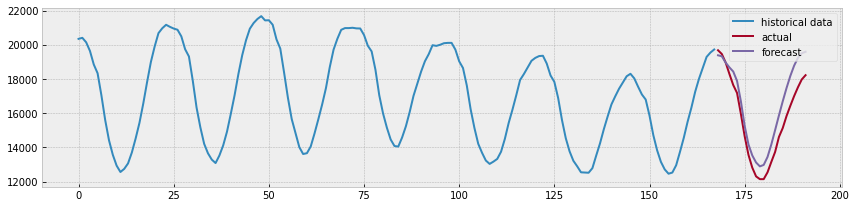

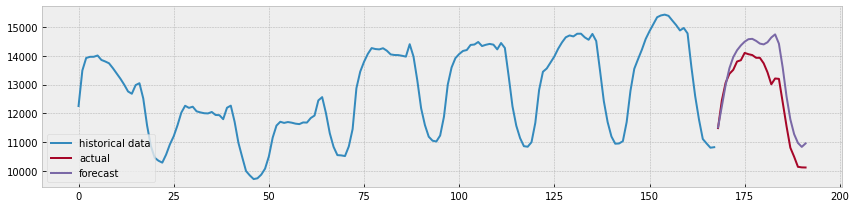

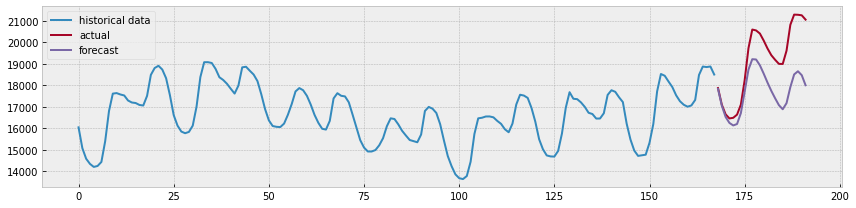

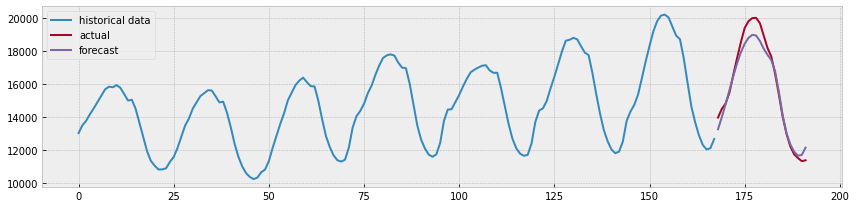

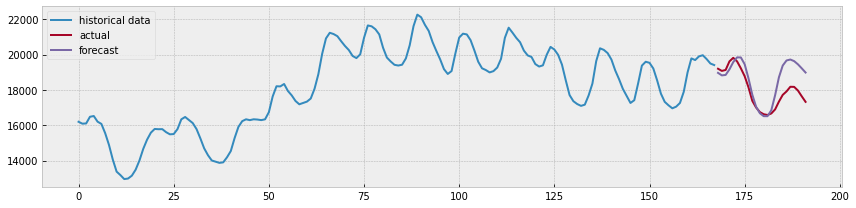

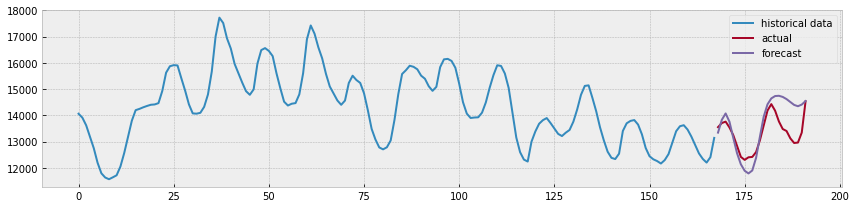

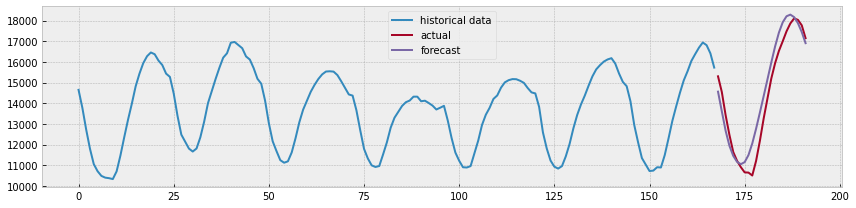

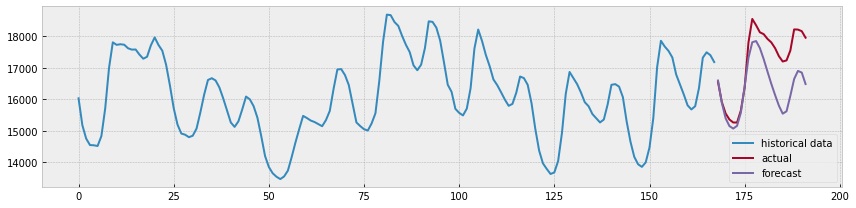

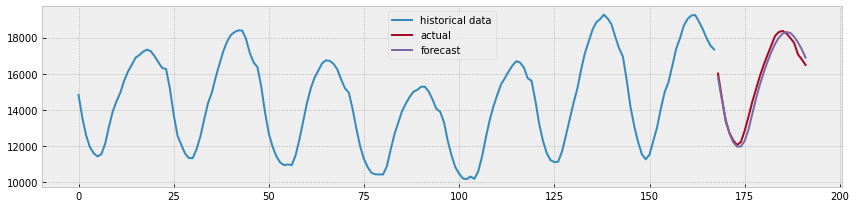

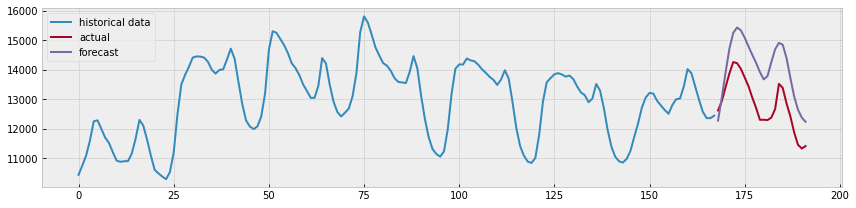

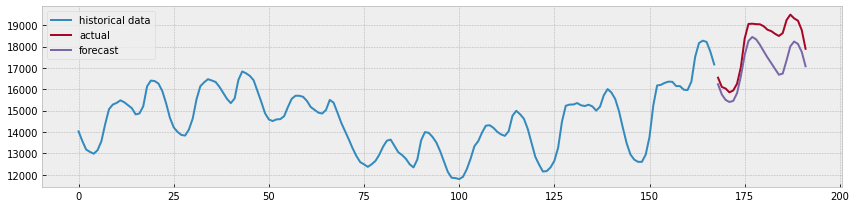

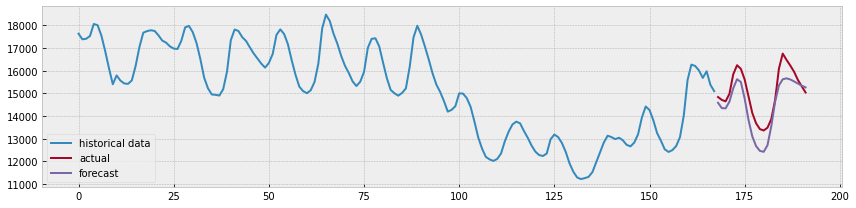

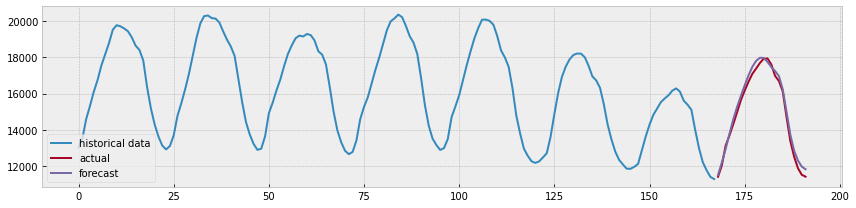

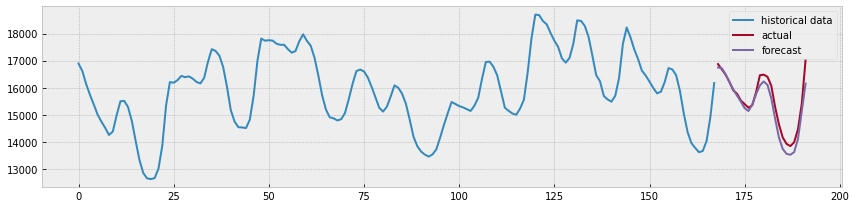

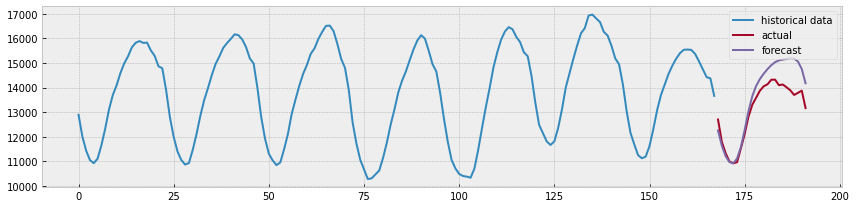

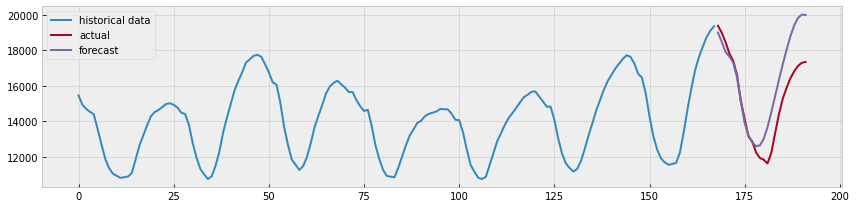

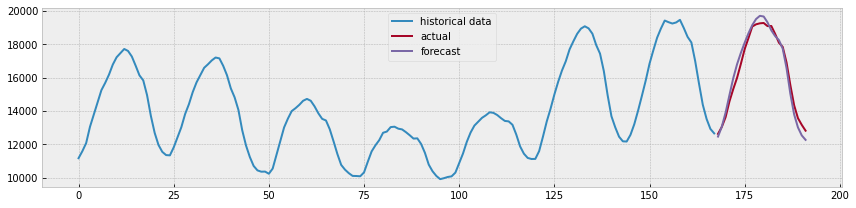

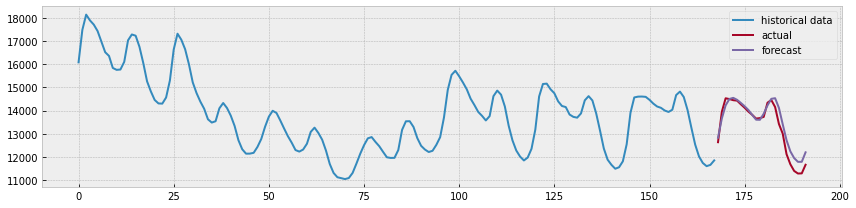

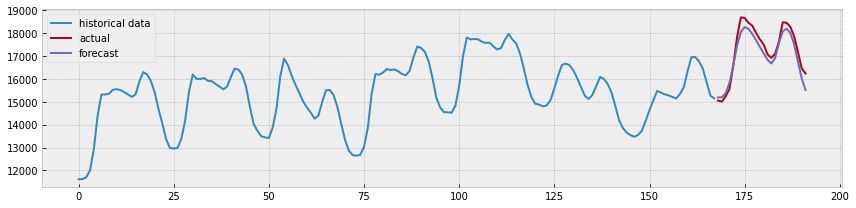

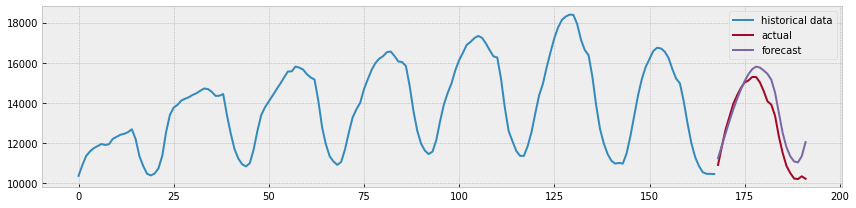

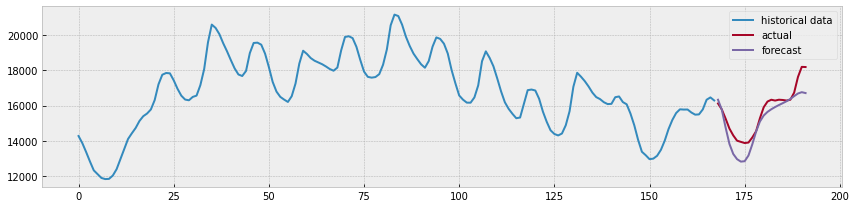

In [107]:
for stream in range(32):
    plt.figure(figsize=(12,3))
    plt.plot((x[0][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="historical data")
    plt.plot(np.arange(168, 192, 1), (x[1][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="actual")
    plt.plot(np.arange(168, 192, 1), (fct[stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="forecast")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()